# data preparation

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from tqdm.notebook import tqdm
import time

# Use project root relative to current working directory; fallback to parent when running from Scripts/
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'Dataset').exists() and (PROJECT_ROOT.parent / 'Dataset').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

INPUT_CSV = PROJECT_ROOT / 'Dataset/train_data_for_modeling(no_standardization).csv'
TEST_CSV = PROJECT_ROOT / 'Dataset/test_data_for_modeling.csv'
NUMERIC_LIST_JSON = PROJECT_ROOT / 'Dataset/numerical_features.json'
OUTPUT_DIR = PROJECT_ROOT / 'Models/LightGBM_notebook'
SCALER_PKL = PROJECT_ROOT / 'Dataset/features_standard_scaler.pkl'

TARGET_COL = 'RESALE_PRICE' 
USE_NUMERIC_LIST = False   
USE_SCALER = True            
RANDOM_STATE = 42
TEST_SIZE = 0.2

ESTIMATOR_STEP = 10 
PRED_BATCH_SIZE = 10000 

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print('Config loaded.')


Config loaded.


In [3]:
import json
from typing import List, Tuple


def load_feature_list(path: Path) -> List[str]:
    with open(path, 'r', encoding='utf-8') as f:
        cols = json.load(f)
    seen = set()
    ordered = []
    for c in cols:
        if c not in seen:
            seen.add(c)
            ordered.append(c)
    return ordered


def prepare_features(df: pd.DataFrame, target: str, use_numeric_list: bool,
                     numeric_list: List[str] | None) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    leakage = {'RESALE_PRICE', 'LOG_RESALE_PRICE'}
    X = df.drop(columns=[c for c in leakage if c in df.columns])
    if target not in df.columns:
        raise ValueError(f'{target} not found in dataframe')
    if use_numeric_list:
        if numeric_list is None:
            raise ValueError('use_numeric_list=True but numeric_list is empty')
        keep = [c for c in numeric_list if c in X.columns]
        if not keep:
            raise ValueError('numerical_features.json columns not found in dataframe')
        X = X[keep]
    y = df[target].astype(float)
    return X, y, list(X.columns)


def build_pipeline(**rf_params) -> Pipeline:
    pre = ColumnTransformer(
        transformers=[('num', SimpleImputer(strategy='median'), slice(0, None))],
        remainder='drop',
        verbose_feature_names_out=False,
    )
    model = RandomForestRegressor(**rf_params)
    return Pipeline(steps=[('preprocess', pre), ('model', model)])


def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {'rmse': rmse, 'mae': mae, 'r2': r2}


def save_artifacts(output_dir: Path, pipeline: Pipeline, feature_names: List[str],
                   metrics: dict, split_tag: str) -> None:
    output_dir.mkdir(parents=True, exist_ok=True)
    # Write metrics.json
    metrics_path = output_dir / 'metrics.json'
    all_metrics = {}
    if metrics_path.exists():
        try:
            all_metrics = json.loads(metrics_path.read_text(encoding='utf-8'))
        except Exception:
            all_metrics = {}
    all_metrics[split_tag] = metrics
    metrics_path.write_text(json.dumps(all_metrics, ensure_ascii=False, indent=2), encoding='utf-8')

    # save model
    joblib.dump(pipeline, output_dir / 'random_forest_pipeline.joblib')

    # save feature importances
    try:
        rf: RandomForestRegressor = pipeline.named_steps['model']
        importances = getattr(rf, 'feature_importances_', None)
        if importances is not None:
            fi = pd.DataFrame({'feature': feature_names, 'importance': importances}) \
                 .sort_values('importance', ascending=False)
            fi.to_csv(output_dir / 'feature_importances.csv', index=False)
    except Exception:
        pass

print('Functions ready.')


Functions ready.


In [4]:
# Read data and prepare features
raw = pd.read_csv(INPUT_CSV)
print('Train shape:', raw.shape)

num_list = None
if USE_NUMERIC_LIST and NUMERIC_LIST_JSON.exists():
    num_list = load_feature_list(NUMERIC_LIST_JSON)

X, y, feature_names = prepare_features(raw, TARGET_COL, USE_NUMERIC_LIST, num_list)
if 'USE_SCALER' in globals() and USE_SCALER:
    num_cols = load_feature_list(NUMERIC_LIST_JSON)
    use_cols = [c for c in num_cols if c in X.columns]
    scaler = joblib.load(SCALER_PKL)
    scaled_num = pd.DataFrame(
        scaler.transform(X.loc[:, use_cols].astype('float64')),
        index=X.index,
        columns=use_cols,
    )
    X = X.drop(columns=use_cols).join(scaled_num)
    X = X[feature_names]

print('Feature shape:', X.shape, 'Target shape:', y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False
)
print('Train/Val sizes:', X_train.shape, X_val.shape)


Train shape: (162570, 89)
Feature shape: (162570, 87) Target shape: (162570,)
Train/Val sizes: (130056, 87) (32514, 87)


# lightgbm

In [5]:
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pre = ColumnTransformer(
    [('num', SimpleImputer(strategy='median'), slice(0, None))],
    remainder='drop', verbose_feature_names_out=False
)

lgbm = lgb.LGBMRegressor(
    n_estimators=5000, learning_rate=0.05, num_leaves=63,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, objective='regression', metric='rmse',
    random_state=42, n_jobs=-1
)

pipe_lgbm = Pipeline([('preprocess', pre), ('model', lgbm)])

pipe_lgbm.fit(
    X_train, y_train,
    model__eval_set=[(X_val, y_val)],
    model__callbacks=[
        lgb.early_stopping(stopping_rounds=200),  
        lgb.log_evaluation(period=100)             
    ]
)

pred_tr = pipe_lgbm.predict(X_train)
pred_val = pipe_lgbm.predict(X_val)
metrics_train = evaluate(y_train, pred_tr)
metrics_val   = evaluate(y_val, pred_val)
print('Train:', metrics_train)
print('Val  :', metrics_val)

pipe = pipe_lgbm  
pipe = pipe_lgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4698
[LightGBM] [Info] Number of data points in the train set: 130056, number of used features: 85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 518991.821582
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 38201
[200]	valid_0's rmse: 31645.3
[300]	valid_0's rmse: 29299.9
[400]	valid_0's rmse: 28233.8
[500]	valid_0's rmse: 27658
[600]	valid_0's rmse: 27301.4
[700]	valid_0's rmse: 27059.8


KeyboardInterrupt: 

In [ ]:
# save model and metrics
import os, time, json
from threading import Thread
from IPython.display import display

COMPRESS_LEVEL = 0     
SAVE_PIPELINE  = True  

target_path = OUTPUT_DIR / ('lgbm_pipeline_best.joblib' if SAVE_PIPELINE else 'rf_model.joblib')
obj_to_save = pipe if SAVE_PIPELINE else pipe.named_steps['model']

def _dump_model():
    joblib.dump(obj_to_save, target_path, compress=COMPRESS_LEVEL, protocol=5)

print('Start saving to:', target_path, flush=True)
t0 = time.time()
worker = Thread(target=_dump_model, daemon=True)
worker.start()

h = display('Saving model ... 0s', display_id=True)
last_txt = None
while worker.is_alive():
    try:
        size = os.path.getsize(target_path) if os.path.exists(target_path) else 0
    except Exception:
        size = 0
    txt = f"Saving model ... {int(time.time()-t0)}s, size={size/1024/1024:.1f}MB"
    if txt != last_txt:
        h.update(txt)
        last_txt = txt
    time.sleep(1)

worker.join()
dt = time.time() - t0
size_mb = (os.path.getsize(target_path) / 1024 / 1024) if os.path.exists(target_path) else 0.0
h.update(f"Saved in {dt:.1f}s, final size={size_mb:.1f}MB")

# save metrics
metrics_path = OUTPUT_DIR / 'lgbm_metrics_best.json'
all_metrics = {}
if metrics_path.exists():
    try:
        all_metrics = json.loads(metrics_path.read_text(encoding='utf-8'))
    except Exception:
        all_metrics = {}
all_metrics['train'] = metrics_train
all_metrics['val']   = metrics_val
metrics_path.write_text(json.dumps(all_metrics, ensure_ascii=False, indent=2), encoding='utf-8')

# save feature importances
try:
    rf = pipe.named_steps['model']
    fi = pd.DataFrame({'feature': feature_names, 'importance': rf.feature_importances_}) \
         .sort_values('importance', ascending=False)
    fi.to_csv(OUTPUT_DIR / 'lgbm_feature_importances_best.csv', index=False)
except Exception as e:
    print('Skip feature importances:', e)

Start saving to: /Users/yangkexin/Documents/CS5228/Project/cs5228_PROJ/Models/random_forest_notebook/lightboost_pipeline_best.joblib


'Saved in 1.0s, final size=27.8MB'

In [ ]:
# predict test set
if TEST_CSV.exists():
    test_df = pd.read_csv(TEST_CSV)
    # same feature selection and order as training
    test_X = test_df.copy()
    for col in ['RESALE_PRICE', 'LOG_RESALE_PRICE']:
        if col in test_X.columns:
            test_X = test_X.drop(columns=[col])
    if USE_NUMERIC_LIST and num_list is not None:
        keep = [c for c in num_list if c in test_X.columns]
        test_X = test_X[keep]
    else:
        missing_cols = [c for c in feature_names if c not in test_X.columns]
        for c in missing_cols:
            test_X[c] = np.nan
        extra_cols = [c for c in test_X.columns if c not in feature_names]
        if extra_cols:
            test_X = test_X.drop(columns=extra_cols)
        test_X = test_X[feature_names]

    preds = []
    for i in tqdm(range(0, len(test_X), PRED_BATCH_SIZE), desc='Predicting test', unit='rows'):
        batch = test_X.iloc[i:i+PRED_BATCH_SIZE]
        preds.append(pipe.predict(batch))
    test_pred = np.concatenate(preds, axis=0)

    # raw predictions
    raw_out = OUTPUT_DIR / 'lgbm_test_predictions_best.csv'
    pd.DataFrame({'prediction': test_pred}).to_csv(raw_out, index=False)

    # generate submission file
    submit_out = OUTPUT_DIR / 'lgbm_submission_best.csv'
    submit_df = pd.DataFrame({'Id': np.arange(len(test_pred), dtype=int), 'Predicted': test_pred})
    submit_df.to_csv(submit_out, index=False)

    print('Raw predictions saved to:', raw_out)
    print('Submission saved to    :', submit_out)
else:
    print('TEST_CSV not found, skip test set prediction.')


Predicting test:   0%|          | 0/5 [00:00<?, ?rows/s]

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Raw predictions saved to: /Users/yangkexin/Documents/CS5228/Project/cs5228_PROJ/Models/random_forest_notebook/lightboost_test_predictions_best.csv
Submission saved to    : /Users/yangkexin/Documents

In [ ]:
# predict test set
if TEST_CSV.exists():
    test_df = pd.read_csv(TEST_CSV)
    # same feature selection and order as training
    test_X = test_df.copy()
    for col in ['RESALE_PRICE', 'LOG_RESALE_PRICE']:
        if col in test_X.columns:
            test_X = test_X.drop(columns=[col])
    if USE_NUMERIC_LIST and num_list is not None:
        keep = [c for c in num_list if c in test_X.columns]
        test_X = test_X[keep]
    else:
        missing_cols = [c for c in feature_names if c not in test_X.columns]
        for c in missing_cols:
            test_X[c] = np.nan
        extra_cols = [c for c in test_X.columns if c not in feature_names]
        if extra_cols:
            test_X = test_X.drop(columns=extra_cols)
        test_X = test_X[feature_names]

    preds = []
    for i in tqdm(range(0, len(test_X), PRED_BATCH_SIZE), desc='Predicting test', unit='rows'):
        batch = test_X.iloc[i:i+PRED_BATCH_SIZE]
        preds.append(pipe.predict(batch))
    test_pred = np.concatenate(preds, axis=0)

    # raw predictions
    raw_out = OUTPUT_DIR / 'lgbm_test_predictions_600.csv'
    pd.DataFrame({'prediction': test_pred}).to_csv(raw_out, index=False)

    # generate submission file
    submit_out = OUTPUT_DIR / 'lgbm_submission_600.csv'
    submit_df = pd.DataFrame({'Id': np.arange(len(test_pred), dtype=int), 'Predicted': test_pred})
    submit_df.to_csv(submit_out, index=False)

    print('Raw predictions saved to:', raw_out)
    print('Submission saved to    :', submit_out)
else:
    print('TEST_CSV not found, skip test set prediction.')


## Random search

In [6]:
# random search
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
import numpy as np, time

X_search = pd.concat([X_train, X_val], axis=0)
y_search = pd.concat([y_train, y_val], axis=0)
test_fold = np.r_[np.full(len(X_train), -1), np.zeros(len(X_val), dtype=int)]
cv = PredefinedSplit(test_fold)

pre = Pipeline([('preprocess', pre)]) 
base_lgbm = lgb.LGBMRegressor(
    objective='regression', metric='rmse',
    random_state=42, n_jobs=-1
)
pipe_lgbm = Pipeline([('preprocess', pre), ('model', base_lgbm)])

param_distributions = {
    'model__n_estimators': [2000, 3000, 4000, 5000, 6000],
    'model__learning_rate': [0.03, 0.05, 0.07],
    'model__num_leaves': [31, 63, 127],                
    'model__max_depth': [-1, 8, 10, 12],
    'model__min_data_in_leaf': [50, 100, 200, 300],    
    'model__feature_fraction': [0.6, 0.7, 0.8, 0.9],
    'model__bagging_fraction': [0.6, 0.7, 0.8, 0.9],
    'model__bagging_freq': [1],
    'model__min_gain_to_split': [0.0, 0.02, 0.05, 0.1],
    'model__lambda_l1': [0, 0.1, 0.5, 1.0],
    'model__lambda_l2': [0, 5, 10, 20, 50],
}

rs = RandomizedSearchCV(
    estimator=pipe_lgbm,
    param_distributions=param_distributions,
    n_iter=40,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, verbose=1, random_state=42, refit=True
)

print('Start LGBM RS aligned to your val split...')
t0 = time.time()
rs.fit(
    X_search, y_search,
    model__eval_set=[(X_val, y_val)],
    model__callbacks=[lgb.early_stopping(stopping_rounds=200),
                      lgb.log_evaluation(period=100)]
)
print(f'Done in {time.time()-t0:.1f}s')
print('Best params:', rs.best_params_)
print('CV (your val) RMSE:', -rs.best_score_)

best_pipe = rs.best_estimator_
pred_tr = best_pipe.predict(X_train)
pred_val = best_pipe.predict(X_val)
print('Train:', evaluate(y_train, pred_tr))
print('Val  :', evaluate(y_val, pred_val))
pipe = best_pipe

Start LGBM RS aligned to your val split...
Fitting 1 folds for each of 40 candidates, totalling 40 fits
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lam

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's rmse: 26949.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current v

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's rmse: 26409.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[1500]	valid_0's rmse: 27605.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3400]	valid_0's rmse: 26382.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's rmse: 26218.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1700]	valid_0's rmse: 26285.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2600]	valid_0's rmse: 26190.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[1800]	valid_0's rmse: 26296.2
Early stopping, best iteration is:
[1611]	valid_0's rmse: 26277.6
[2100]	valid_0's rmse: 26337.7


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[400]	valid_0's rmse: 30608.8
[2800]	valid_0's rmse: 26142.6
[100]	valid_0's rmse: 38285.4
[1800]	valid_0's rmse: 26580.6
[2200]	valid_0's rmse: 26310
[500]	valid_0's rmse: 29616
[2300]	valid_0's rmse: 

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[400]	valid_0's rmse: 29045.6
[2600]	valid_0's rmse: 26219.6
[900]	valid_0's rmse: 27785
[100]	valid_0's rmse: 38251.5
[200]	valid_0's rmse: 33840.3
[LightGBM] [Warning] No further splits with posit

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[400]	valid_0's rmse: 29693.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[3900]	valid_0's rmse: 26032.1
[3000]	valid_0's rmse: 25937.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1800]	valid_0's rmse: 26042.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1900]	valid_0's rmse: 26781.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 29640.6
[2100]	valid_0's rmse:

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1900]	valid_0's rmse: 26032.1
[500]	valid_0's rmse: 28862
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3400]	valid_0's rmse: 26200.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's rmse: 25791.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4600]	valid_0's rmse: 25852.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3400]	valid_0's rmse: 26496.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1600]	valid_0's rmse: 26441.3
[400]	valid_0's rmse: 30871.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 28807.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3100]	valid_0's rmse: 26878.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[3504]	valid_0's rmse: 26059.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[3543]	valid_0's rmse: 26056.3


/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[3300]	valid_0's rmse: 26033.9
[3400]	valid_0's rmse: 26033.8
[3500]	valid_0's rmse: 26035.9
[3600]	valid_0's rmse: 26036.2
[3700]	valid_0's rmse: 26033
[3800]	valid_0's rmse: 26036.5
Early stopping, 

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/multimodal_rag_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Train: {'rmse': 17820.247331849823, 'mae': 13283.296716163011, 'r2': 0.9905335673521417}
Val  : {'rmse': 17713.358337426238, 'mae': 13246.839346003975, 'r2': 0.9907063222819172}


In [7]:
# 1) get best params
best_model_in_cv = rs.best_estimator_.named_steps['model']
best_iter = getattr(best_model_in_cv, 'best_iteration_', None) or getattr(best_model_in_cv, 'best_iteration', None)

best_params = {k.replace('model__',''): v for k, v in rs.best_params_.items()}
if best_iter is not None:
    best_params['n_estimators'] = int(best_iter) 

# 2) retrain with best params on full data (Train+Val)
final_lgbm = lgb.LGBMRegressor(objective='regression', metric='rmse',
                               random_state=42, n_jobs=-1, **best_params)
final_pipe = Pipeline([('preprocess', pre), ('model', final_lgbm)])
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)
final_pipe.fit(X_full, y_full)

# 3) cover pipe, the following save and test set prediction units can be run directly
pipe = final_pipe

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

In [12]:
# 假设搜索对象名为 rs 或 random_search_lgbm
cv_lgbm = pd.DataFrame(rs.cv_results_)
cv_lgbm.to_csv(OUTPUT_DIR / 'lgbm_cv_results.csv', index=False)

with open(OUTPUT_DIR / 'lgbm_best_params.json', 'w') as f:
    json.dump(rs.best_params_, f, indent=2)

# plot

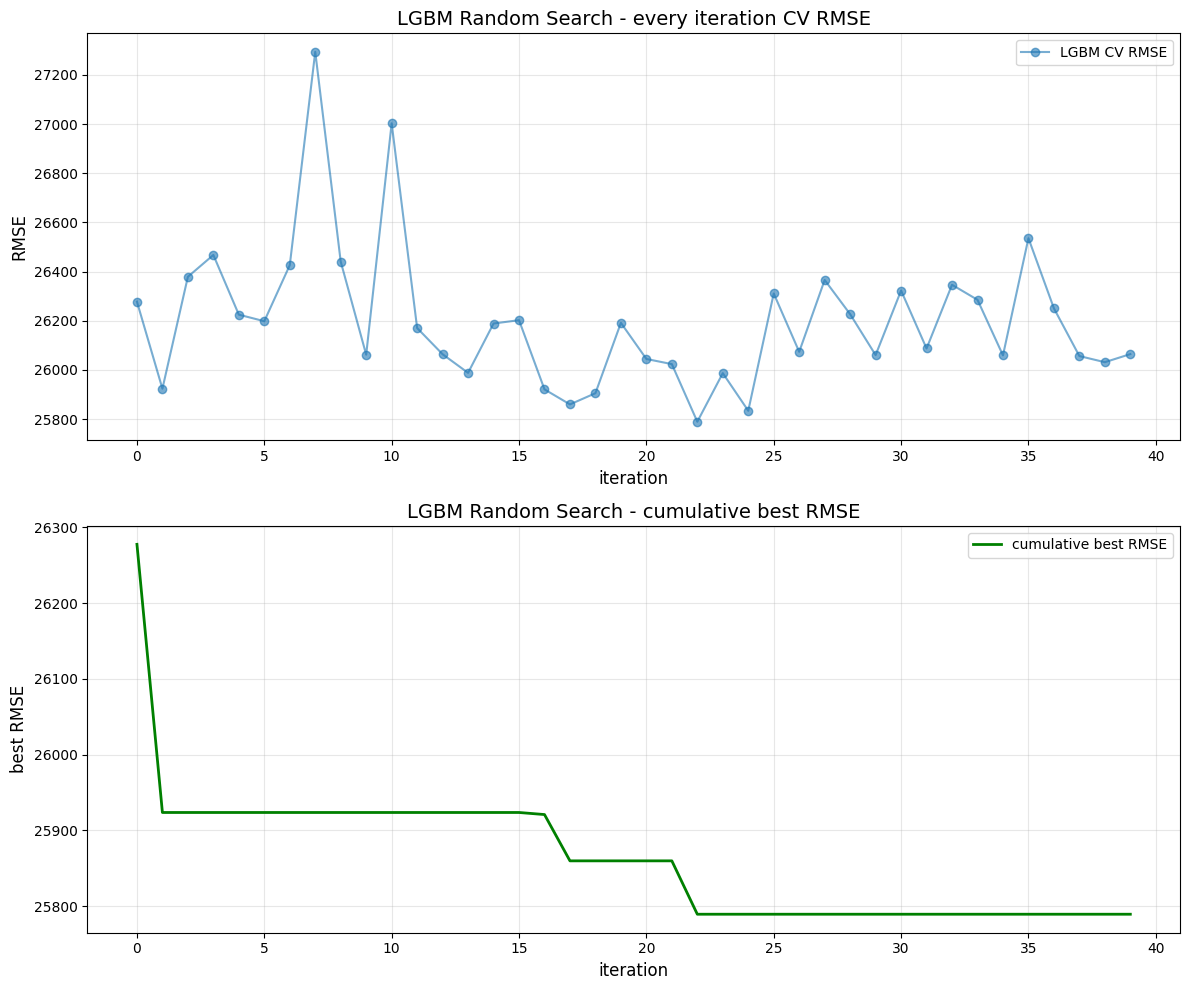

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pick the LGBM search object
search = None
for cand in ['rs', 'random_search_lgbm', 'random_search']:
    if cand in globals():
        search = globals()[cand]
        break
assert search is not None, "RandomizedSearchCV object not found. Please set `search` to your LGBM search result."

cv_results = pd.DataFrame(search.cv_results_)

mean_test_scores = -cv_results['mean_test_score']  # neg RMSE -> RMSE
std_test_scores  =  cv_results['std_test_score']
cumulative_best  = np.minimum.accumulate(mean_test_scores.values)

BASELINE = None  # 可填入你的基线 RMSE，如 31133.04；不需要就保持 None

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# (1) every iteration
axes[0].plot(range(len(mean_test_scores)), mean_test_scores, 'o-', alpha=0.6, label='LGBM CV RMSE')
axes[0].fill_between(range(len(mean_test_scores)),
                     mean_test_scores - std_test_scores,
                     mean_test_scores + std_test_scores,
                     alpha=0.2)
if BASELINE is not None:
    axes[0].axhline(y=BASELINE, color='r', linestyle='--', label='Baseline RMSE')
axes[0].set_xlabel('iteration', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('LGBM Random Search - every iteration CV RMSE', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# (2) cumulative best
axes[1].plot(range(len(cumulative_best)), cumulative_best, 'g-', linewidth=2, label='cumulative best RMSE')
if BASELINE is not None:
    axes[1].axhline(y=BASELINE, color='r', linestyle='--', label='Baseline RMSE')
axes[1].set_xlabel('iteration', fontsize=12)
axes[1].set_ylabel('best RMSE', fontsize=12)
axes[1].set_title('LGBM Random Search - cumulative best RMSE', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

mdl = pipe.named_steps['model']
# evals_result_ 结构：{'valid_0': {'rmse': [ ... ]}} 或 {'training': {...}, 'valid_1': {...}} 等
res = getattr(mdl, 'evals_result_', None)
if res is None:
    raise RuntimeError("No evals_result_ found. Ensure you fit with callbacks and eval_set.")

# 尝试自动找第一个验证集 key
valid_key = None
for k in res.keys():
    if k.lower().startswith('valid'):
        valid_key = k; break
if valid_key is None:
    # fallback: pick any key that isn't 'training'
    valid_key = [k for k in res.keys() if k.lower()!='training'][0]

rmse_curve = res[valid_key]['rmse']
plt.figure(figsize=(10,4))
plt.plot(range(1, len(rmse_curve)+1), rmse_curve, label=f'{valid_key} rmse')
plt.xlabel('boosting iteration')
plt.ylabel('RMSE')
plt.title('LGBM Learning Curve on Validation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

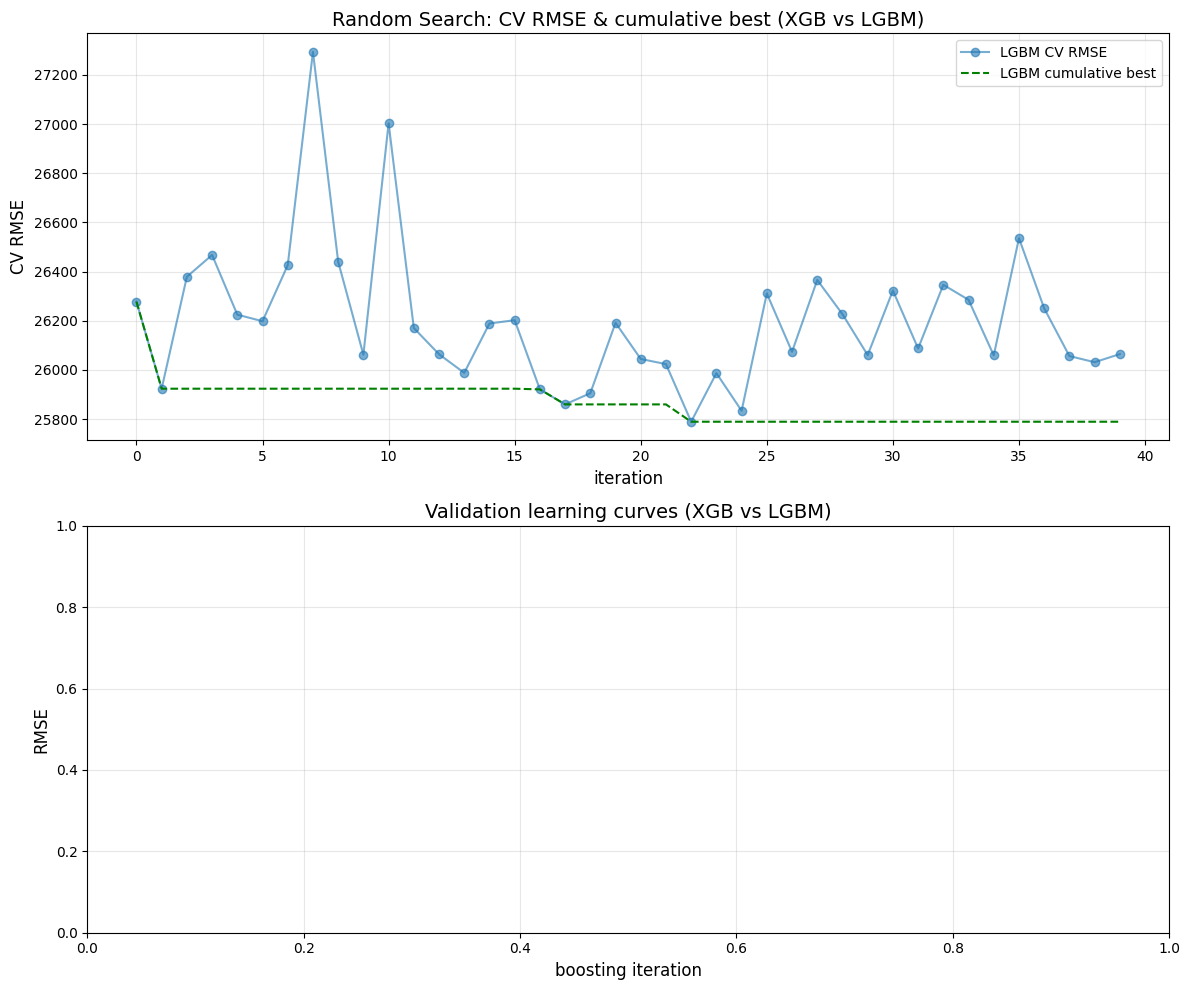

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) 指定/自动识别搜索对象与最优管道（不成功就手动设）
def pick_first(names):
    for n in names:
        if n in globals():
            return globals()[n]
    return None

xgb_search = pick_first(['random_search_xgb', 'xgb_search', 'random_search'])
lgbm_search = pick_first(['rs', 'random_search_lgbm', 'lgbm_search', 'random_search'])

xgb_pipe   = pick_first(['pipe_xgb', 'best_pipe_xgb', 'pipe'])
lgbm_pipe  = pick_first(['pipe_lgbm', 'best_pipe', 'pipe'])

# 如果自动识别失败，请手动指定：
# xgb_search = your_xgb_random_search
# lgbm_search = your_lgbm_random_search
# xgb_pipe = your_best_xgb_pipeline
# lgbm_pipe = your_best_lgbm_pipeline

def get_cv_curve(search):
    if search is None: return None, None, None
    cv = pd.DataFrame(search.cv_results_)
    mean = -cv['mean_test_score'].values
    std  =  cv['std_test_score'].values
    best = np.minimum.accumulate(mean)
    return mean, std, best

def get_valid_curve(pipe):
    if pipe is None: return None
    mdl = pipe.named_steps.get('model', None)
    if mdl is None: return None
    res = getattr(mdl, 'evals_result_', None)
    if not res: return None
    # 选第一个 valid*
    valid_key = next((k for k in res.keys() if k.lower().startswith('valid')), None)
    if valid_key is None:
        # 兜底：除 training 外任一
        ks = [k for k in res.keys() if k.lower() != 'training']
        valid_key = ks[0] if ks else list(res.keys())[-1]
    curve = res[valid_key].get('rmse', None)
    return curve

xgb_mean, xgb_std, xgb_best = get_cv_curve(xgb_search)
lgb_mean, lgb_std, lgb_best = get_cv_curve(lgbm_search)

xgb_valid_curve = get_valid_curve(xgb_pipe)
lgb_valid_curve = get_valid_curve(lgbm_pipe)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# (A) Random search CV RMSE overlay
ax = axes[0]
if xgb_mean is not None:
    ax.plot(range(len(xgb_mean)), xgb_mean, 'o-', alpha=0.6, label='XGB CV RMSE')
    ax.fill_between(range(len(xgb_mean)), xgb_mean - xgb_std, xgb_mean + xgb_std, alpha=0.12)
    ax.plot(range(len(xgb_best)), xgb_best, 'r--', linewidth=1.5, label='XGB cumulative best')
if lgb_mean is not None:
    ax.plot(range(len(lgb_mean)), lgb_mean, 'o-', alpha=0.6, label='LGBM CV RMSE')
    ax.fill_between(range(len(lgb_mean)), lgb_mean - lgb_std, lgb_mean + lgb_std, alpha=0.12)
    ax.plot(range(len(lgb_best)), lgb_best, 'g--', linewidth=1.5, label='LGBM cumulative best')

ax.set_xlabel('iteration', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Random Search: CV RMSE & cumulative best (XGB vs LGBM)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# (B) Validation learning curves overlay (if available)
ax2 = axes[1]
plotted = False
if xgb_valid_curve is not None:
    ax2.plot(range(1, len(xgb_valid_curve)+1), xgb_valid_curve, label='XGB valid rmse')
    plotted = True
if lgb_valid_curve is not None:
    ax2.plot(range(1, len(lgb_valid_curve)+1), lgb_valid_curve, label='LGBM valid rmse')
    plotted = True

ax2.set_xlabel('boosting iteration', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('Validation learning curves (XGB vs LGBM)', fontsize=14)
ax2.grid(True, alpha=0.3)
if plotted: ax2.legend()

plt.tight_layout()
plt.show()